This tutorial is generated from a [Jupyter](http://jupyter.org/) notebook that can be found [here](https://github.com/elfi-dev/notebooks).

### Robust Optimisation Monte Carlo [ROMC](http://proceedings.mlr.press/v108/ikonomov20a) - Implemenation at ELFI: [Vasilis Gkolemis](https://givasile.github.io)

This tutorial covers the basics of using ROMC inference method at ELFI.

---
**Background**

Every random generation process can be converted to a determintic, if we pre-sample the random variables. Let's use as an example, a simple sampling process from a normal Gaussian centered at $\theta$: $x \leftarrow \theta + v_i$, where $v_i \sim N(0,1)$

We can map this process to a deterministic function, if we just pre-sample $v_i \sim N(0,1)$: $x = f(\theta, v=v_i) = v_i + \theta$

This simple idea can be generalised to much more complex random processes.

In terms of a computer program, the situation is even more convenient. The starting point of all the (pseudo)randomness is the initial `seed`. So we can convert any ranom generation process to a deterministic, simply by setting to initial seed to a pre-defined value, before starting the process.

```Python
# random process
def f(th):
    rv = ss.norm(loc=th)
    return rv.rvs()
```

```Python
# deterministic process
def f(th, seed):
    rv = ss.norm(loc=th)
    return rv.rvs(random_state=seed)
```
---
**Method Description**

ROMC fundamental idea is to map a random simulator to many deterministic functions $f_i(\theta)$ (each one with different seed), by presampling many different seeds. Process $f_i$ corresponds to the $i-th$ sampled `seed`.

For each $f_i(\theta)$ we search for the set of parameters $\theta$, that generate output as close as possible to the observed data $x_0$. We solve that as an optimisation problem:

$$\theta_i^* = argmin_{\theta} L(f_i(\theta), x_0), \text{where L is any valid distance}$$

Then we search for the area $S_i$ around $\theta_i^*$, where the distance to the observed data remains below a certain threshold $ S_i = \{ \theta \in \mathbb{R}^D: L(f_i(\theta), x_0) \leq \tau \}$.

The sum of all these areas $S_i \forall i$ corresponds to the approximate posterior.

For more information about the method and its theoretical background, you can check [here](https://givasile.github.io/assets/pdf/edinburgh_thesis.pdf) and [here](http://proceedings.mlr.press/v108/ikonomov20a).

---
This tutorial demonstrates how to apply `ROMC` for solving the MA2 problem at `ELFI`.

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import elfi
from elfi.examples import ma2
import logging
import graphviz

logging.basicConfig(level=logging.INFO)
np.random.seed(seed = 1)


Let's first observe the `MA2` model

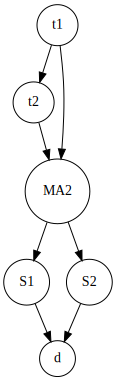

In [77]:
# load model
model = ma2.get_model(seed_obs = 1)

# render and view the DAG
node_names = list(model.nodes())
output_node_name = node_names[-1]
output_node = model.get_reference(output_node_name)
elfi.draw(output_node)

In [78]:
# generate samples 
output = model.generate(batch_size=2, outputs=['t1', 't2', 'MA2', 'S1', 'S2', 'd'])

# and observe the output arrays
print("Shapes of ouputs")
print("th1:     ", output['t1'].shape)
print("th2     :", output['t2'].shape)
print("sim     :", output['MA2'].shape)
print("sum1    :", output['S1'].shape)
print("sum2    :", output['S2'].shape)
print("d       :", output['d'].shape)

Shapes of ouputs
th1:      (2,)
th2     : (2,)
sim     : (2, 100)
sum1    : (2,)
sum2    : (2,)
d       : (2,)


### ROMC method initialization

Romc doesn't need any argument to initialize. It is good, though, to pass the bounds of the prior distribution for enabling some feature we will discuss later (e.g. the Bayesian Optimisation scheme)

In [38]:
# define prior bounds
bounds = [(-2,2), (-2,2)]

# init romc method
romc = elfi.ROMC(model, bounds=bounds, discrepancy_name="d")

### Training (Fitting) part

In the training part, the algorithm 

* transforms the random sampling process into deterministic optimisation problems
* solves the optimisation problems (using gradient-based optimiser or Bayesian Optimisation)
* estimates the acceptance regions around the solutions, as bounding-boxes 


The training part, exposes 3 functionalities:

* `solve_problems(n1, use_bo=False)`: draws `n1` nuisance variables and solves `n1` optimisation problems. If `use_bo=True`, Bayesian Optimization is used instead of a gradient-based optimiser and a Gaussian Process is fitted as a surrogate model of the distance to the observed data.


* `estimate_regions(eps_filter, fit_models=False)`: Filters solutions that are above the threshold `eps_filter` and for the rest it builds the N-Dimensional bounding box around the optimal point $\theta_i^*$. If `fit_models=True`, it fits a helping quadratic model of the distance around the optimal point. 


* `fit_posterior(n1, eps_filter)`: helping function, that combines both above steps above in a single call.

The functions above can take more optional arguments (e.g. parameters for the optimizer), that we do not discuss here. If you want the complete description read the [docs](https://elfi.readthedocs.io/en/latest/api.html#elfi.ROMC) or the pdf [here](https://givasile.github.io/assets/pdf/edinburgh_thesis.pdf)

In [40]:
n1 = 300
seed = None
romc.solve_problems(n1=n1, seed=seed)

INFO:elfi.methods.inference.romc:### Solving problems using a gradient-based method ###


Solving gradients


INFO:elfi.methods.inference.romc:Time: 11.228 sec
INFO:elfi.methods.inference.romc:Time: 11.229 sec


Progress [==================================================] 100.0% Complete


### Inspecting the optimisation results

* `theta_hist(**kwargs)`: plots a histogram of the distances $d_i^* = L(f_i(\theta_i^*), x_0)$ between the optimal points and the observed data. Inspecting, this histogram is a good indicator for deciding the threshold `eps_filter` before calling `estimate_regions()`. `**kwargs` are passed below to `plt.hist`

In the current example, a threshold close to `0.2` seems a good choice.

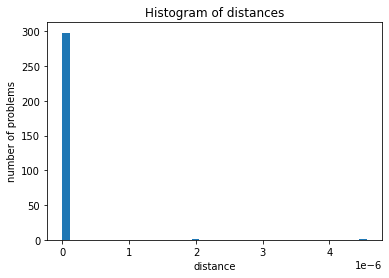

In [41]:
# get the histogram of the optimal points
romc.distance_hist(bins=40)

In [42]:
# estimate bounding box regions
eps_filter = .02
romc.estimate_regions(eps_filter=eps_filter, fit_models=True, eps_cutoff=0.1)

INFO:elfi.methods.inference.romc:Total solutions: 300, Accepted solutions after filtering: 300
INFO:elfi.methods.inference.romc:### Estimating regions ###



Building boxes


INFO:elfi.methods.inference.romc:Time: 6.215 sec 

INFO:elfi.methods.inference.romc:### Fitting local models ###



Progress [==================================================] 100.0% Complete
Fitting models
Progress [==================================================] 100.0% Complete


INFO:elfi.methods.inference.romc:Time: 8.221 sec 



### Visualize the acceptance regions

* `visualize_region(i)`: plots the area around $\theta_*^{(i)}$, for the i-th optimisation problem. Works only in 1D and 2D parameter spaces. It is useful to get an insight how the surface region looks like.

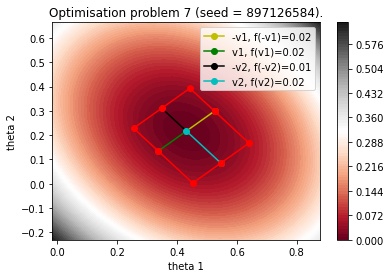

In [44]:
romc.visualize_region(7)

### Inference part

Now that the posterior approximation has been built, we can proceed to the inference part. Romc method exposes 4 functionalities, the first two are the basic ones (`sample` and `compute_expectation`) an the other two are more experimental (`eval_unnorm_posterior`, `eval_posterior`)

**Basic**:

* `sample(n2)`: samples `n2` weighted samples per accepted region. In total, we will get $n_{acc} n_2$ where samples, where $n_{acc} \leq n_1$ is the number of accepted regions after filtering


* `compute_expectation(h)`: approximates the expected value $E_{P(\theta|data)}[h(\theta)]$ as $\frac{\sum_i h(\theta_i)w_i}{\sum_i w_i}$. `h` can be any callable that accepts a `np.array` of shape `(batch_size, D)` as input


**Experimental**:

* `eval_unnorm_posterior(theta)`: evaluates the unnormalized approximate posterior at $\theta$. Again, `theta` is a `np.array` of shape `(batch_size, D)`


* `eval_posterior(theta)`: evaluates the normalized posterior at the point $\theta$. The computation can be time consuming since the approximation of the normalization constant $Z$ is done in a naive way (Riemann approximation). Hence, it is adviced to be used only in low-dimensional parametric spaces ($\leq \textit{3D}$)

In [45]:
# sample 50 points per accepted region
n2 = 50
romc.sample(n2=n2)

INFO:elfi.methods.inference.romc:### Getting Samples from the posterior ###



Sampling posterior regions


INFO:elfi.methods.inference.romc:Time: 16.803 sec 



Progress [==================================================] 100.0% Complete


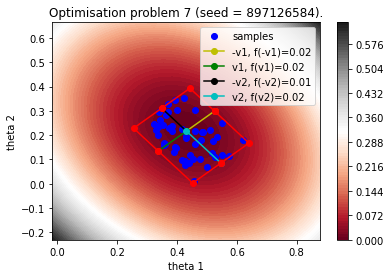

In [47]:
# We can visualize the region as before, now it also plots the samples
romc.visualize_region(7)

### Evaluation Part

Romc provides some functionalities for evaluating the inference

Basic

* `compute_ess`: computes the effective sample size of the weighted samples
* `result.<function>`: we can also use all functionalities and attributes the `results` objects of `ELFI` supports by default e.g. `result.plot_marginals`. Below, we show as examples, some custom plots.


Experimental:

* `compute_divergence(gt_posterior, bounds=None, step=0.1, distance="Jensen-Shannon"):` approximates the divergence between the approximate posterior and the ground truth. Normally, `gt_posterior` is not available (that is the point of inference), but the method still works if another (more robust) approximation is used as ground-truth. The distance can be either Jensen-Shannon (default) or KL-Divergence. The divergence computation is done naively using Riemann's approximation, hence it is adviced to be used in low dimensional spaces.


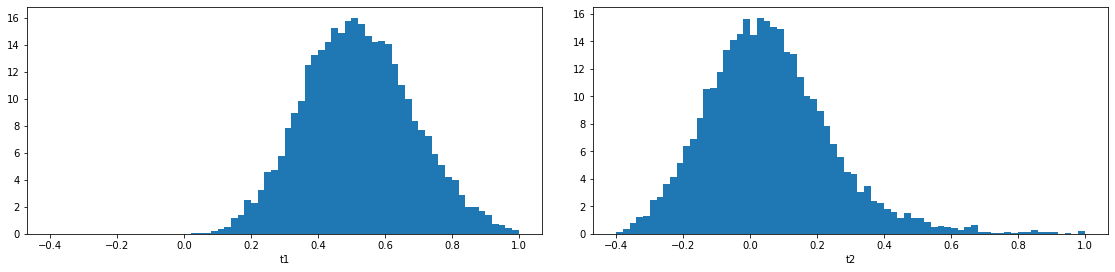

In [50]:
# plot marginal distributions
romc.result.plot_marginals(weights=romc.result.weights, bins=70, range=(-.4, 1))
plt.show()

In [55]:
# print samples mean and covariance
print("Samples mean:")
print(romc.result.sample_means_array)

print("\n")

print("Samples covariance:")
print(romc.result.samples_cov())

Samples mean:
[0.52074447 0.05544873]


Samples covariance:
[[0.02623884 0.0024643 ]
 [0.0024643  0.03470212]]


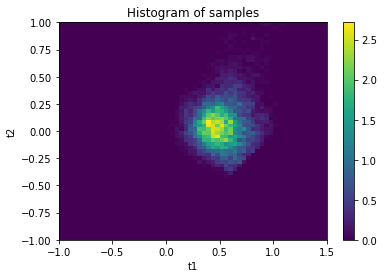

In [60]:
plt.figure()
plt.hist2d(romc.result.samples_array[:,0], romc.result.samples_array[:,1], bins=60, range=[(-1, 1.5), (-1,1)], weights=romc.result.weights)
plt.title("Histogram of samples")
plt.xlabel("t1")
plt.ylabel("t2")
plt.show()

INFO:elfi.methods.inference.romc:Time: 253.910 sec 



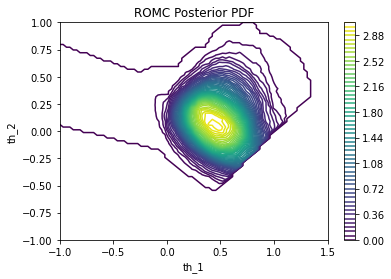

In [21]:
# draw the normalised posterior (it takes around 4mins)
plt.figure()
th1 = np.linspace(-1, 1.5, nof_points)
th2 = np.linspace(-1, 1, nof_points)
X, Y = np.meshgrid(th1, th2)

x_flat = X.flatten()
y_flat = Y.flatten()
th = np.stack((x_flat, y_flat), -1)
z_flat = romc.eval_posterior(th)
Z = z_flat.reshape(nof_points, nof_points)
    
plt.contourf(X, Y, Z, 50, cmap='viridis')
plt.title('ROMC Unnormalized posterior')
plt.xlabel("t1")
plt.ylabel("t2")
plt.colorbar()
plt.show(block=False)

### Alternative choice: use the Bayesian Optimization scheme for the optimization part

ROMC offers the alternative to use Bayesian Optimisation for solving the optimisation problems. If this option is chosen, a Gaussian Process surrogate model of the distance is fitted. Some remarks:

* Bayesian Optimisation is adviced to be used when gradient-approximation is computationally inefficient or when the objective function is not smooth and gradient-based optimisation leads to inconistencies.
* In the Bayesian Optimisation set-up the fitting part is slower (compared to the case where gradients are efficiently accesible), but the inference part (sampling or evaluating the approximate posterior) is much faster.

In the rest of the notebook, we follow the same process as before.

In [63]:
bounds = [(-2,2), (-2,2)]
romc = elfi.ROMC(model, bounds=bounds, discrepancy_name="d")

In [64]:
# takes almost 8 minutes (much slower)
n1 = 100
seed = 21
romc.solve_problems(n1=n1, seed=seed, use_bo=True)

INFO:elfi.methods.inference.romc:### Solving problems using Bayesian optimisation ###


Bayesian Optimization
Progress [==================================================] 100.0% Complete


INFO:elfi.methods.inference.romc:Time: 494.673 sec
INFO:elfi.methods.inference.romc:Time: 494.674 sec


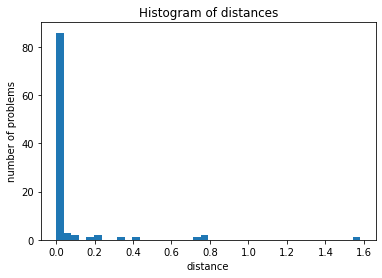

In [65]:
romc.distance_hist(bins=40)

In [66]:
# takes almost 1 second (much faster)
eps_filter = .02
romc.estimate_regions(eps_filter=eps_filter, fit_models=True, eps_cutoff=0.1)

INFO:elfi.methods.inference.romc:Total solutions: 100, Accepted solutions after filtering: 83
INFO:elfi.methods.inference.romc:### Estimating regions ###



Building boxes


INFO:elfi.methods.inference.romc:Time: 0.883 sec 

INFO:elfi.methods.inference.romc:### Fitting local models ###



Progress [==================================================] 100.0% Complete
Fitting models


INFO:elfi.methods.inference.romc:Time: 0.907 sec 



Progress [==================================================] 100.0% Complete


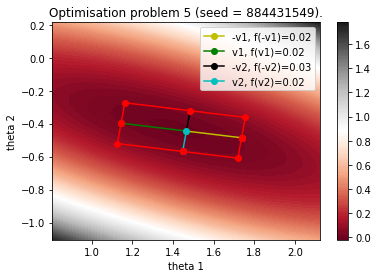

In [67]:
romc.visualize_region(5)

In [68]:
# takes almost 2 seconds (much faster)
n2 = 50
tmp = romc.sample(n2=n2)

INFO:elfi.methods.inference.romc:### Getting Samples from the posterior ###



Sampling posterior regions


INFO:elfi.methods.inference.romc:Time: 4.656 sec 



Progress [==================================================] 100.0% Complete


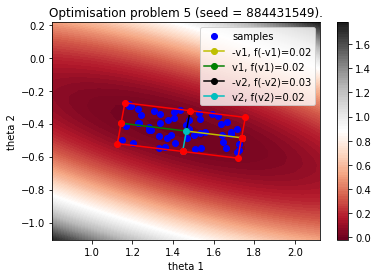

In [69]:
# As before but now it plots the samples as well
romc.visualize_region(5)

# Evaluation

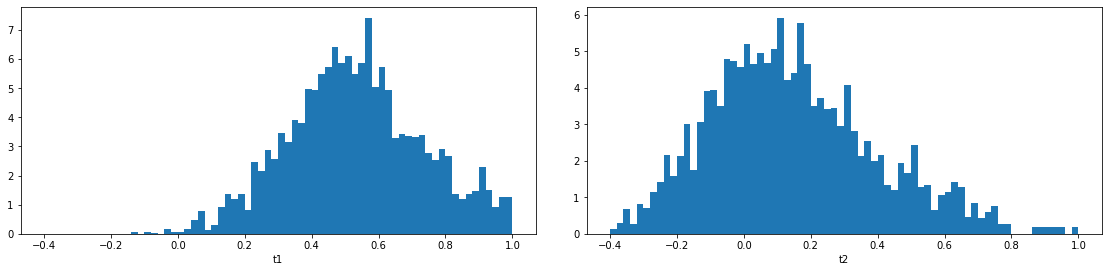

In [70]:
# plot marginal distributions
romc.result.plot_marginals(weights=romc.result.weights, bins=70, range=(-.4, 1))
plt.show()

In [71]:
# print samples mean and covariance
print("Samples mean:")
print(romc.result.sample_means_array)

print("\n")

print("Samples covariance:")
print(romc.result.samples_cov())

Samples mean:
[0.54743783 0.13451738]


Samples covariance:
[[0.04815927 0.01173694]
 [0.01173694 0.0720636 ]]


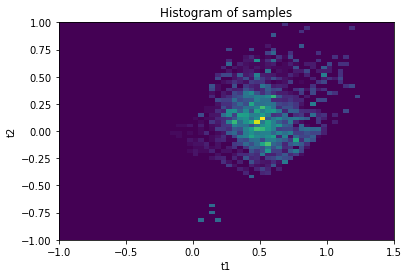

In [72]:
plt.figure()
plt.hist2d(romc.result.samples_array[:,0], romc.result.samples_array[:,1], bins=60, range=[(-1, 1.5), (-1,1)], weights=romc.result.weights)
plt.title("Histogram of samples")
plt.xlabel("t1")
plt.ylabel("t2")
plt.show()

INFO:elfi.methods.inference.romc:Time: 77.969 sec 



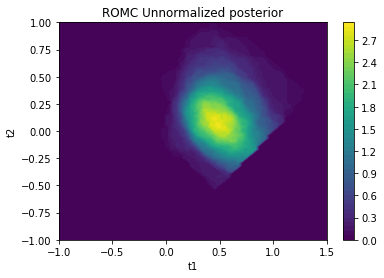

In [75]:
# takes around 1min (much faster)
nof_points = 80
plt.figure()
th1 = np.linspace(-1, 1.5, nof_points)
th2 = np.linspace(-1, 1, nof_points)
X, Y = np.meshgrid(th1, th2)

x_flat = X.flatten()
y_flat = Y.flatten()
th = np.stack((x_flat, y_flat), -1)
z_flat = romc.eval_posterior(th)
Z = z_flat.reshape(nof_points, nof_points)
    
plt.contourf(X, Y, Z, 50, cmap='viridis')
plt.title('ROMC Unnormalized posterior')
plt.xlabel("t1")
plt.ylabel("t2")
plt.colorbar()
plt.show(block=False)

In this tutorial we covered the basic functionalities of the `ROMC` inference method.

Some more examples can be found here:

* [Simple 1D example](https://colab.research.google.com/drive/1lGRp0XrNfZ64NN0ASB_tYEKowXwlveDC)
* [Simple 2D example](https://colab.research.google.com/drive/1Fof_WmCi1YizzSI_63aEsbLXsno5gSZ3)
* [MA2 example](https://colab.research.google.com/drive/1nkdACQ370SSc0KB1bHv4sBRaxMlMqoNH)
* [Extending the method example](https://colab.research.google.com/drive/1RzB-V1QueP1y1nyzv_VOqR1nVz3DUH3v)


As a conclusion, we show a graphical overview of `ROMC` implementation. 

---
**Graph with `ROMC` implementation**

![title](resources/ROMC.png)